## 1. **Business Understanding**

### Overview

SentimentFlow aims to address a real-world problem related to understanding public sentiment towards Apple and Google products on Twitter. The stakeholders include companies, marketing teams, and decision-makers who want to gauge public opinion and make informed strategic decisions based on social media sentiment.

### Problem Statement

The problem is to accurately classify the sentiment of tweets related to Apple and Google products. We want to determine whether a tweet expresses a positive, negative, or neutral sentiment. This classification can help companies understand customer satisfaction, identify potential issues, and tailor their responses accordingly.

### Objectives

Main Objective

> To develop a NLP (Natural Language Processing) multiclass classification model for sentiment analysis, aim to achieve a recall score of 80% and an accuracy of 80%. The model should categorize sentiments into three classes: Positive, Negative, and Neutral.

Specific Objectives

* To idenitfy the most common words used in the dataset using Word cloud.

* To confirm the most common words that are positively and negatively tagged.

* To recognize the products that have been opined by the users.

* To spot the distribution of the sentiments.

## 2. **Data Understanding**

### Data Sources
The dataset originates from CrowdFlower via data.world. Contributors evaluated tweets related to various brands and products. Specifically:
- Each tweet was labeled as expressing positive, negative, or no emotion toward a brand or product.
- If emotion was expressed, contributors specified which brand or product was the target.

### Suitability of Data
Here's why this dataset is suitable for our project:
1. **Relevance:** The data directly aligns with our business problem of understanding Twitter sentiment for Apple and Google products.
2. **Real-World Context:** The tweets represent actual user opinions, making the problem relevant in practice.
3. **Multiclass Labels:** We can build both binary (positive/negative) and multiclass (positive/negative/neutral) classifiers using this data.

### Dataset Size
The dataset contains over 9,000 labeled tweets. We'll explore its features to gain insights.

### Descriptive Statistics
- **tweet_text:** The content of each tweet.
- **is_there_an_emotion_directed_at_a_brand_or_product:** No emotion toward brand or product, Positive emotion, Negative emotion, I can't tell
- **emotion_in_tweet_is_directed_at:** The brand or product mentioned in the tweet.

### Feature Inclusion
Tweet text is the primary feature. The emotion label and target brand/product are essential for classification.

### Limitations
- **Label Noise:** Human raters' subjectivity may introduce noise.
- **Imbalanced Classes:** We'll address class imbalance during modeling.
- **Contextual Challenges:** Tweets are often short and context-dependent.
- **Incomplete & Missing Data:** Could affect the overall performance of the models.

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


Load and Inspect data

In [52]:
# from typing_extensions import dataclass_transform
class DataUnderstanding:
  """Class for understanding the characteristics of the dataset"""
  def __init__(self, data= None):
    """Initialize the class with a DataFrame"""
    self.df= data

  def load_data(self, path):
    """Load data from a CSV file"""
    if self.df is None:
      self.df = pd.read_csv(path, encoding= 'latin-1')
    return self.df

  def preview_df(self):
    """Preview the DataFrame"""
    print("\n\nHEAD")
    print("-"*22)
    print(self.df.head())

  def display_info(self):
    """Display information about the DataFrame"""
    print("\n\nINFO")
    print("-"*22)
    print(self.df.info())

  def display_shape(self):
    """Display the shape of the DataFrame"""
    print("\n\nSHAPE")
    print("-"*22)
    print(f"Records: {self.df.shape[0]}, Features: {self.df.shape[1]}")

  def display_columns(self):
    """Display the columns in the dataset."""
    print("\nCOLUMNS")
    print("-" *22)
    for col in self.df.columns:
      print(f"- {col}")


  def display_missing_values(self):
    """Display missing values in each column"""
    print("\n\nMISSING VALUES")
    print("-"*22)
    for col in self.df.columns:
      print(f"{col}: {self.df[col].isnull().sum()}")

  def display_duplicates(self):
    """Display duplicate records in the DataFrame"""
    print("\n\nDUPLICATES")
    print("-"*22)
    print(f"Duplicate records: {self.df.duplicated().sum()}")

  def understand_data(self):
    """Display dataset overview"""
    self.preview_df()
    self.display_info()
    self.display_shape()
    self.display_columns()
    self.display_missing_values()
    self.display_duplicates()




In [53]:
# Load Data
data_und = DataUnderstanding()

df = data_und.load_data('/content/drive/MyDrive/phase_4_project/sentiment-analysis/judge-1377884607_tweet_product_company.csv')

data_und.understand_data()



HEAD
----------------------
                                          tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion  


INFO
----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 

In essence, the dataset is designed to analyze sentiment, whether positive or negative, from tweets involving different products or brands.

The majority of these tweets - 5802 - don't specify any product or brand for which some decisions may be required in pre-processing.

The dataset is fairly clean; there are a few missing values in the 'tweet_text' and 'emotion_in_tweet_is_directed_at' columns and few duplicates.

Data Cleaning

In [54]:
#renaming columns for easier reference
df.rename (columns= {
    'tweet_text': 'tweets',
    'emotion_in_tweet_is_directed_at': 'product',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'
}, inplace=True)

Handling duplicates

In [55]:
df.drop_duplicates(subset= 'tweets', inplace= True)

Handling missing values

In [56]:
# Drop the 1 in tweets column
df = df.dropna(subset=['tweets'])

In [57]:
# imputing missing values in product column with data from tweets

product_list = df['product'].unique()
product_list = [product for product in product_list if str(product) != 'nan']

def extract_product(tweet):
    for product in product_list:
        if product.lower() in tweet.lower():
            return product
    return None

df.loc[:, 'product']  = df.apply(lambda x: extract_product(x['tweets']) if pd.isna(x['product']) else x['product'], axis=1,)

df.head(5)

,tweets,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [58]:
df['product'].isnull().sum()

759

In [59]:
# drop the remaining
df = df.dropna(subset=['product'])

In [60]:
#check distribution of emotions
df['emotion'].value_counts()

,count
emotion,
No emotion toward brand or product,4633
Positive emotion,2955
Negative emotion,568
I can't tell,150


In [61]:
#drop records where emotion is i can't tell
df = df.drop(df[df['emotion'] == "I can't tell"].index)

In [62]:
# label emotion as 'positive', 'negative' and 'neutral'
df.loc[:, 'sentiment'] = df['emotion'].apply(lambda x: 'positive' if x == 'Positive emotion' else ('negative' if x == 'Negative emotion' else 'neutral'))
df.head()

,tweets,product,emotion,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,positive


In [63]:
#Ensure cleaning process worked effectively
data_und = DataUnderstanding(df)

data_und.understand_data()



HEAD
----------------------
                                              tweets             product  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3  @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   

            emotion sentiment  
0  Negative emotion  negative  
1  Positive emotion  positive  
2  Positive emotion  positive  
3  Negative emotion  negative  
4  Positive emotion  positive  


INFO
----------------------
<class 'pandas.core.frame.DataFrame'>
Index: 8156 entries, 0 to 9092
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweets     8156 non-null   object
 1   product    8156 non-null   object
 2   emotion    8156 non-null   ob

**Exploratory Data Analysis**

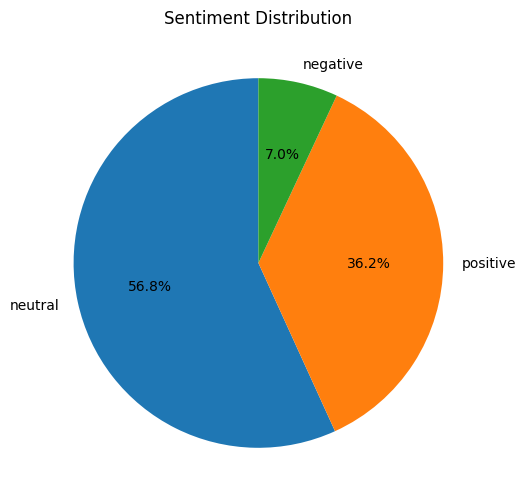

In [64]:
#sentiment distribution
sentiment_counts = df['sentiment'].value_counts()

# piechart
plt.figure(figsize=(8, 6))
labels= sentiment_counts.index
plt.pie(sentiment_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution')
plt.show()


Class Imbalance is evident, seeing as more than 50% of the tweets convey neutral emotion and approximately 7% convey negative emotion.

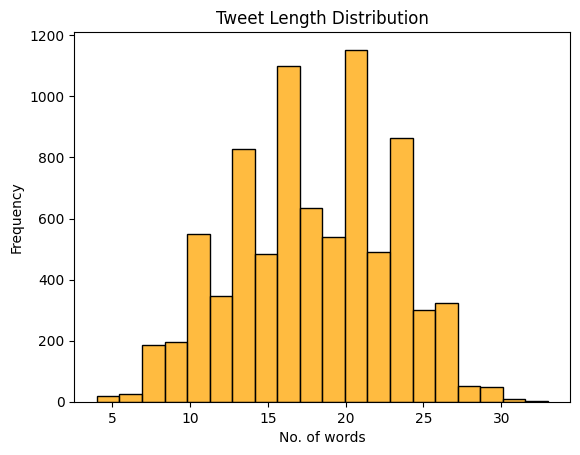

In [65]:
# tweet length distribution
df['tweet_length'] = df['tweets'].apply(lambda x: len(x.split()))

sns.histplot(df['tweet_length'], bins=20, color= 'orange')
plt.title('Tweet Length Distribution')
plt.xlabel('No. of words')
plt.ylabel('Frequency')
plt.show()


The tweets range between 4 and 33 words

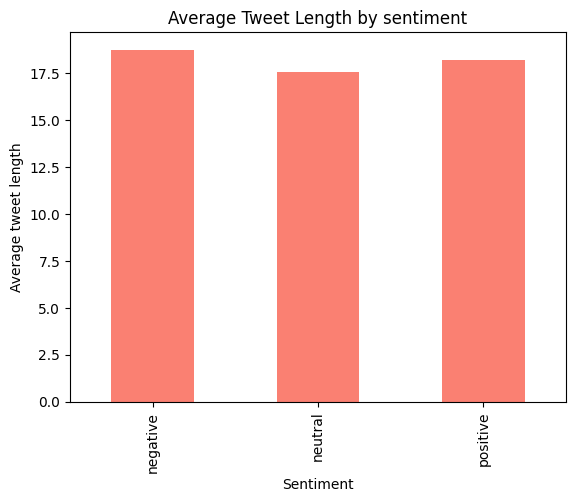

In [66]:
#Class Distribution by tweet length
df.groupby('sentiment')['tweet_length'].mean().plot(kind='bar', color= 'salmon')
plt.title('Average Tweet Length by sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average tweet length')
plt.show()


The bar chart indicates that the average tweet length for all three sentiment categories (positive, negative, and neutral) is almost equal, ranging between 17 to 18 words, suggesting that tweet length is consistent across different sentiments.

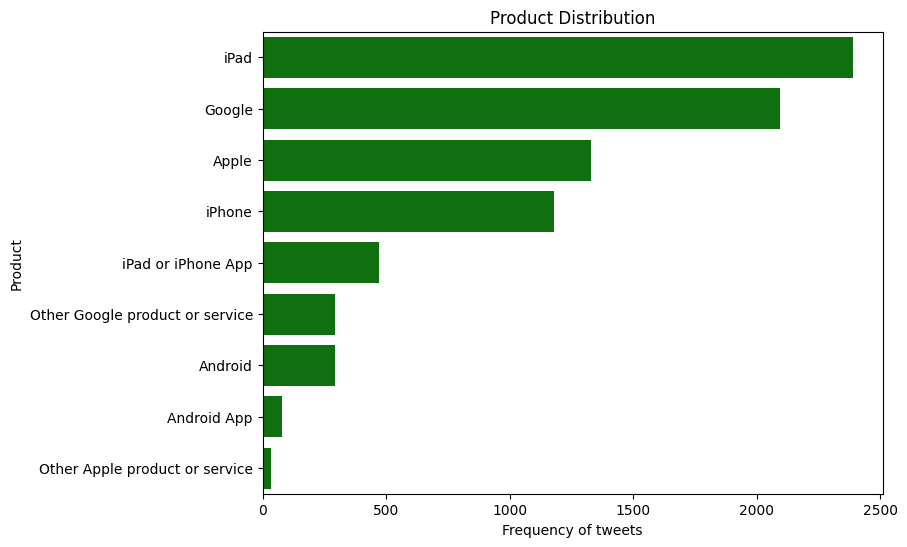

,count
product,
iPad,2390
Google,2093
Apple,1328
iPhone,1178
iPad or iPhone App,469
Other Google product or service,292
Android,291
Android App,80
Other Apple product or service,35


In [67]:
#Distribution of products
product_counts= df['product'].value_counts()

plt.figure(figsize= (8, 6))
labels= product_counts.index
sns.barplot(x= product_counts, y= labels, color= 'green')
plt.title('Product Distribution')
plt.xlabel('Frequency of tweets')
plt.ylabel('Product')
plt.show()

product_counts

The distribution plot of product distribution shows that iPad is the most mentioned product among the tweets, followed by Google and Apple, which proves these brands are on the hotlist and much discussed, whereas the rest of the products like Android and Apple services have been talked about far less.

<Figure size 800x600 with 0 Axes>

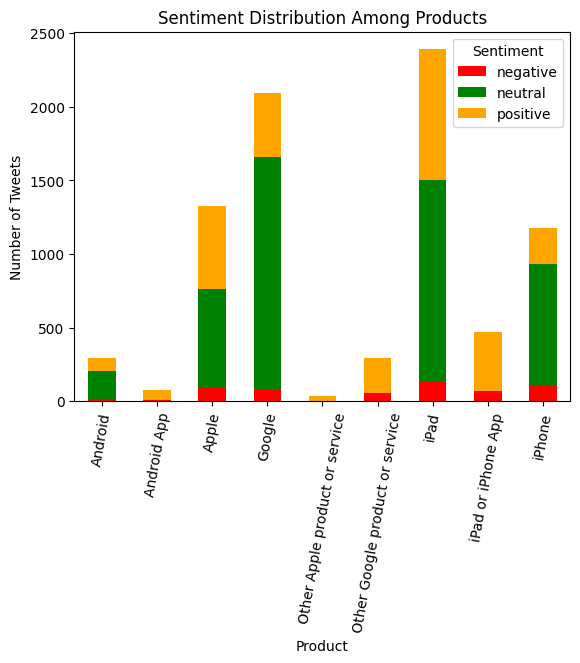

In [68]:
#Sentiment distribution for each product
product_sentiment_counts = df.groupby('product')['sentiment'].value_counts().unstack().fillna(0)

#plot
plt.figure(figsize=(8, 6))

# Plot the sentiment distribution for each product
product_sentiment_counts.plot(kind='bar', stacked=True, color=['red', 'green', 'orange'])

plt.title('Sentiment Distribution Among Products')
plt.xlabel('Product')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=80)
plt.legend(title='Sentiment', labels=product_sentiment_counts.columns)

plt.show()


**Data Preprocessing**

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [70]:
# text preprocessing

class TextCleaner(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def clean_text(text):
            text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
            text = re.sub(r'@\w+', '', text)  # Remove mentions
            text = re.sub(r'#\w+', '', text)  # Remove hashtags
            text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters and numbers
            text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
            return text
        return [clean_text(text) for text in X]

class LowerCaseConverter(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [text.lower() for text in X]

class StopwordRemover(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        stop_words = set(stopwords.words('english'))
        return [' '.join([word for word in text.split() if word not in stop_words]) for text in X]

class Tokenizer(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [word_tokenize(text) for text in X]

class Lemmatizer(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        lemmatizer = WordNetLemmatizer()
        # Process each token list and lemmatize tokens
        return [[lemmatizer.lemmatize(word) for word in tokens] for tokens in X]



In [71]:
# Pipeline for text preprocessing
text_preprocessing_pipeline = Pipeline([
    ('cleaner', TextCleaner()),
    ('lower_case_converter', LowerCaseConverter()),
    ('stopwords_remover', StopwordRemover()),
    ('tokenizer', Tokenizer()),
    ('lemmatizer', Lemmatizer())
])

df['processed_tweets'] = text_preprocessing_pipeline.fit_transform(df['tweets'])

df['cleaned_tweets'] = df['processed_tweets'].apply(lambda tokens: ' '.join(tokens))

df[['tweets', 'cleaned_tweets']].head(5)


,tweets,cleaned_tweets
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,g iphone hr tweeting dead need upgrade plugin ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,wait also sale
3,@sxsw I hope this year's festival isn't as cra...,hope year festival isnt crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,great stuff fri marissa mayer google tim oreil...


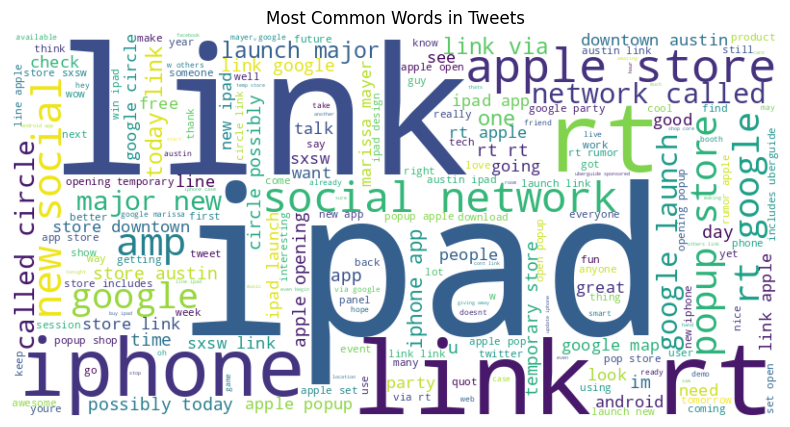

In [72]:
from wordcloud import WordCloud

# Combine all tweets into a single string for word cloud
all_words = ' '.join(df['cleaned_tweets'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Tweets')
plt.show()


**Feature Extraction**

In [73]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [74]:
# Encode the target variable
label_encoder = LabelEncoder()
df['sentiment_enc'] = label_encoder.fit_transform(df['sentiment'])
df.tail()

,tweets,product,emotion,sentiment,tweet_length,processed_tweets,cleaned_tweets,sentiment_enc
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion,positive,4,"[ipad, everywhere, link]",ipad everywhere link,2
9089,"Wave, buzz... RT @mention We interrupt your re...",Google,No emotion toward brand or product,neutral,18,"[wave, buzz, rt, interrupt, regularly, schedul...",wave buzz rt interrupt regularly scheduled gee...,1
9090,"Google's Zeiger, a physician never reported po...",Google,No emotion toward brand or product,neutral,19,"[google, zeiger, physician, never, reported, p...",google zeiger physician never reported potenti...,1
9091,Some Verizon iPhone customers complained their...,iPhone,No emotion toward brand or product,neutral,23,"[verizon, iphone, customer, complained, time, ...",verizon iphone customer complained time fell b...,1
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,Google,No emotion toward brand or product,neutral,9,"[rt, google, test, checkin, offer, link]",rt google test checkin offer link,1


1. Binary Classification

In [75]:
# Filter the dataset to only include positive and negative sentiments
binary_df = df[df['sentiment_enc'].isin([0, 1])].reset_index(drop=True)

X_binary = binary_df['cleaned_tweets']
y_binary = binary_df['sentiment_enc']

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42)


In [76]:
# pipeline with Logistic Regression
binary_lr_pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(class_weight='balanced'))
])

# Fit the Logistic Regression pipeline to the training data
binary_lr_pipeline.fit(X_train_bin, y_train_bin)

#Predict on the test set
y_pred_lr = binary_lr_pipeline.predict(X_test_bin)

#Evaluation for Logistic Regression
binary_accuracy_lr = accuracy_score(y_test_bin, y_pred_lr)
print(f"Logistic Regression Binary Classification Accuracy: {binary_accuracy_lr:.2f}")
print("Logistic Regression Classification Report:\n", classification_report(y_test_bin, y_pred_lr))
print("Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test_bin, y_pred_lr))


Logistic Regression Binary Classification Accuracy: 0.87
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.63      0.50       106
           1       0.96      0.90      0.93       935

    accuracy                           0.87      1041
   macro avg       0.68      0.76      0.71      1041
weighted avg       0.90      0.87      0.88      1041

Logistic Regression Confusion Matrix:
 [[ 67  39]
 [ 96 839]]


In [77]:
#Hyperparameter tuning
lr_param_grid = {
    'lr__C': [0.1, 1, 10, 100],
    'lr__penalty': ['l2'],
    'lr__solver': ['liblinear', 'lbfgs']
}

lr_grid_search = GridSearchCV(binary_lr_pipeline, lr_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
lr_grid_search.fit(X_train_bin, y_train_bin)

# Prediction using the best model
best_lr_model = lr_grid_search.best_estimator_

y_pred_lr_best = best_lr_model.predict(X_test_bin)

# Evaluation for the best Logistic Regression model
binary_accuracy_lr_best = accuracy_score(y_test_bin, y_pred_lr_best)
print(f"Best Logistic Regression Binary Classification Accuracy: {binary_accuracy_lr_best:.2f}")
print("Best Logistic Regression Classification Report:\n", classification_report(y_test_bin, y_pred_lr_best))
print("Best Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test_bin, y_pred_lr_best))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Logistic Regression Binary Classification Accuracy: 0.90
Best Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.52      0.51       106
           1       0.95      0.94      0.94       935

    accuracy                           0.90      1041
   macro avg       0.72      0.73      0.72      1041
weighted avg       0.90      0.90      0.90      1041

Best Logistic Regression Confusion Matrix:
 [[ 55  51]
 [ 56 879]]


In [78]:
#Pipeline with SVM
binary_svm_pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC(class_weight='balanced', random_state=42))
])

binary_svm_pipeline.fit(X_train_bin, y_train_bin)

#Predict on the test set
y_pred_svm = binary_svm_pipeline.predict(X_test_bin)

#Evaluation
binary_accuracy_svm = accuracy_score(y_test_bin, y_pred_svm)
print(f"SVM Binary Classification Accuracy: {binary_accuracy_svm:.2f}")
print("SVM Classification Report:\n", classification_report(y_test_bin, y_pred_svm))
print("SVM Confusion Matrix:\n", confusion_matrix(y_test_bin, y_pred_svm))


SVM Binary Classification Accuracy: 0.91
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.24      0.35       106
           1       0.92      0.99      0.95       935

    accuracy                           0.91      1041
   macro avg       0.79      0.61      0.65      1041
weighted avg       0.89      0.91      0.89      1041

SVM Confusion Matrix:
 [[ 25  81]
 [ 13 922]]


In [79]:
# Hyperparameter tuning for SVM using GridSearchCV
svm_param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto'],
    'svm__kernel': ['linear', 'rbf'],
}

svm_grid_search = GridSearchCV(binary_svm_pipeline, svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
svm_grid_search.fit(X_train_bin, y_train_bin)
# Use the best model from the grid search to make predictions
best_svm_model = svm_grid_search.best_estimator_

# Make predictions using the best Logistic Regression model
y_pred_svm_best = best_svm_model.predict(X_test_bin)

# Evaluation for the best Logistic Regression model
binary_accuracy_svm_best = accuracy_score(y_test_bin, y_pred_svm_best)
print(f"Best Logistic Regression Binary Classification Accuracy: {binary_accuracy_svm_best:.2f}")
print("Best Logistic Regression Classification Report:\n", classification_report(y_test_bin, y_pred_svm_best))
print("Best Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test_bin, y_pred_svm_best))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Logistic Regression Binary Classification Accuracy: 0.91
Best Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.28      0.40       106
           1       0.92      0.99      0.95       935

    accuracy                           0.91      1041
   macro avg       0.81      0.63      0.68      1041
weighted avg       0.90      0.91      0.90      1041

Best Logistic Regression Confusion Matrix:
 [[ 30  76]
 [ 13 922]]


In [80]:
# Compare the models
if binary_accuracy_lr_best > binary_accuracy_svm_best:
    print("Logistic Regression is the better model.")
else:
    print("SVM is the better model.")

SVM is the better model.


2. Multiclass Classification

In [81]:
# Filter the original dataset to include all sentiment classes (negative, positive, neutral)
multi_df= df.copy()
multi_df = df[df['sentiment_enc'].isin([0, 1, 2])].reset_index(drop=True)

print(f"Total tweets for multiclass classification: {multi_df.shape[0]}")
print("Sentiment distribution:\n", multi_df['sentiment_enc'].value_counts())

# Splitting the dataset into features and target variable
X_multi = multi_df['cleaned_tweets']
y_multi = multi_df['sentiment_enc']

# Split the dataset into training and testing sets
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, test_size=0.2, random_state=42, stratify=y_multi)


Total tweets for multiclass classification: 8156
Sentiment distribution:
 sentiment_enc
1    4633
2    2955
0     568
Name: count, dtype: int64


In [82]:
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)  # Set output_dict=True to get it in dictionary form
    cm = confusion_matrix(y_true, y_pred)


    key_metrics = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision (Class 0)': report['0']['precision'],
        'Recall (Class 0)': report['0']['recall'],
        'F1-Score (Class 0)': report['0']['f1-score'],
        'Precision (Class 1)': report['1']['precision'],
        'Recall (Class 1)': report['1']['recall'],
        'F1-Score (Class 1)': report['1']['f1-score'],
        'Confusion Matrix': cm
    }

    return key_metrics


In [83]:
# Define the pipeline
rf_pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

rf_pipeline.fit(X_train_multi, y_train_multi)
y_pred_rf = rf_pipeline.predict(X_test_multi)

results_rf= evaluate_model(y_test_multi, y_pred_rf, 'Random Forest')

In [84]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['auto', 'sqrt', 'log2'],
    'rf__class_weight': ['balanced', 'balanced_subsample']
}

# hyperparameter tuning
random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy',
    random_state=42
)

# Fit the model on the training data
random_search.fit(X_train_multi, y_train_multi)

# best parameters and best accuracy
best_params = random_search.best_params_
best_accuracy = random_search.best_score_

print(f"Best Random Forest Parameters: {best_params}")
print(f"Best Cross-Validated Accuracy: {best_accuracy:.4f}")

# Make predictions using the best model
best_model_rf= random_search.best_estimator_
y_pred_rf_best = best_model_rf.predict(X_test_multi)

# Evaluate the best model
results_rf_best = evaluate_model(y_test_multi, y_pred_rf_best, 'Best Random Forest(Tuned)')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Random Forest Parameters: {'rf__n_estimators': 100, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_features': 'log2', 'rf__max_depth': None, 'rf__class_weight': 'balanced'}
Best Cross-Validated Accuracy: 0.6511


In [85]:
#pipeline with MultinomialNB
pipeline_mnb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

#hyperparameters for grid search
param_grid_mnb = {
    'tfidf__max_df': [0.75, 1.0],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'mnb__alpha': [0.01, 0.1, 1.0]  # Additive smoothing parameter for Naive Bayes
}


grid_search_mnb = GridSearchCV(pipeline_mnb, param_grid_mnb, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)


grid_search_mnb.fit(X_train_multi, y_train_multi)

# Best parameters
print("Best parameters for MNB:", grid_search_mnb.best_params_)


y_pred_mnb = grid_search_mnb.predict(X_test_multi)

results_mnb = evaluate_model(y_test_multi, y_pred_mnb, 'MultinomialNB')

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for MNB: {'mnb__alpha': 0.1, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 2)}


In [86]:
# pipeline with xbg
xgb_pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('xgb', xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42, eval_metric='mlogloss', use_label_encoder=False))
])

# Fit the XGBoost pipeline and evaluate
xgb_pipeline.fit(X_train_multi, y_train_multi)

y_pred_xgb = xgb_pipeline.predict(X_test_multi)

results_xgb = evaluate_model(y_test_multi, y_pred_xgb, 'XGBoost')

In [87]:
#compare models
results = [results_rf, results_rf_best, results_mnb, results_xgb]
results_df = pd.DataFrame(results)
print('\n Model Comparison: \n')

results_df


 Model Comparison: 



,Model,Accuracy,Precision (Class 0),Recall (Class 0),F1-Score (Class 0),Precision (Class 1),Recall (Class 1),F1-Score (Class 1),Confusion Matrix
0,Random Forest,0.644608,0.615385,0.280702,0.385542,0.664260,0.793959,0.723342,"[[32, 69, 13], [16, 736, 175], [4, 303, 284]]"
1,Best Random Forest(Tuned),0.640319,0.645833,0.271930,0.382716,0.664820,0.776699,0.716418,"[[31, 69, 14], [14, 720, 193], [3, 294, 294]]"
2,MultinomialNB,0.644608,0.538462,0.184211,0.274510,0.675752,0.775620,0.722250,"[[21, 70, 23], [14, 719, 194], [4, 275, 312]]"
3,XGBoost,0.667892,0.478873,0.298246,0.367568,0.680035,0.841424,0.752170,"[[34, 63, 17], [26, 780, 121], [11, 304, 276]]"
